In [4]:
import vaft

In [7]:
vaft.database.exist_ts_file()

 Available Thomson Scattering Shots:

|   Index |   Shot Number | Last Processed      | Status       |
|---------|---------------|---------------------|--------------|
|       1 |         40328 | 2023-07-28T16:10:23 | thomson_only |
|       2 |         40327 | 2023-07-28T16:09:09 | core_profile |
|       3 |         40325 | 2023-07-28T16:06:39 | core_profile |
|       4 |         39917 | 2023-07-05T20:47:14 | core_profile |
|       5 |         40323 | 2023-07-28T16:04:09 | core_profile |


In [8]:
ods=vaft.database.load(40327,'public')

Successfully loaded ODS data for shot: 40327


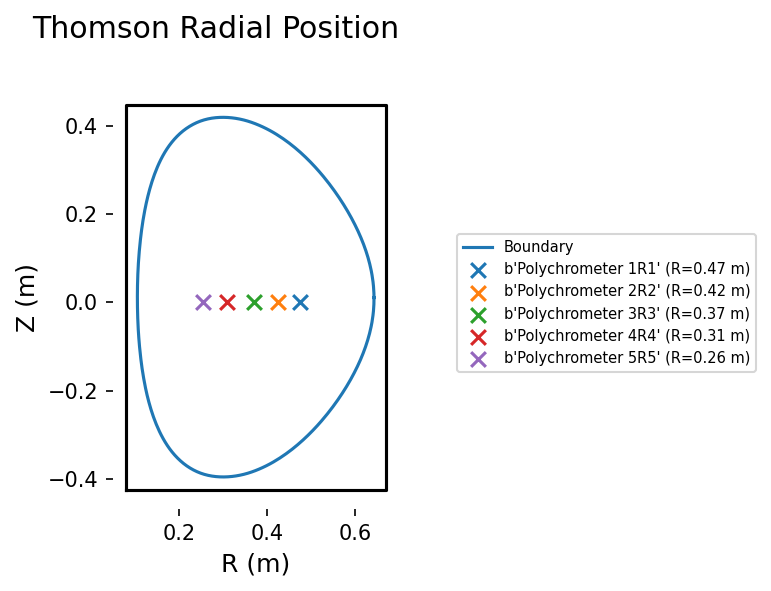

In [ ]:
vaft.plot.profile.plot_thomson_radial_position(ods)

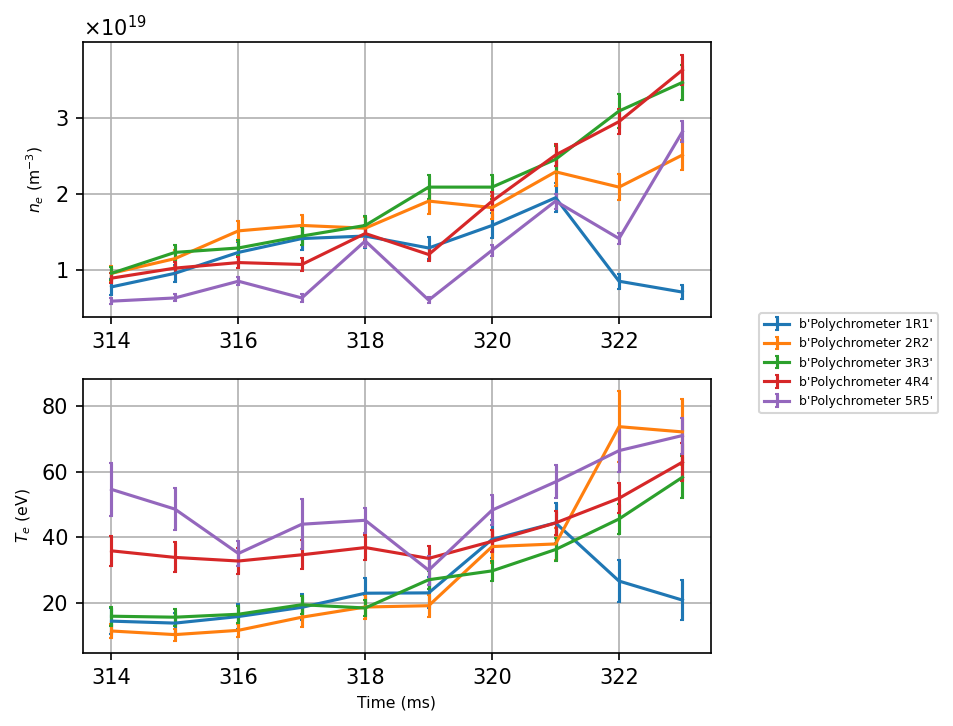

In [11]:
vaft.plot.profile.plot_thomson_time_series(ods)

[INFO] Found 2 fitted core_profiles


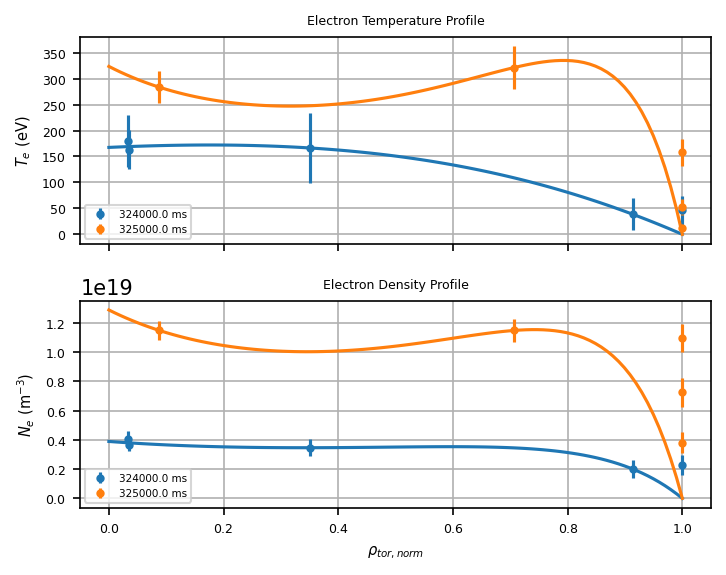

In [6]:
vaft.plot.plot_thomson_profiles(ods)